## E14 - 인물모드 문제점 찾기

### 인물모드 직접 해 보기

In [1]:
import cv2
import numpy as np
import os
from glob import glob
from os.path import join
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/0u2.jpg'
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(609, 540, 3)


In [2]:
# DeepLab 모델 준비하기

class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

In [3]:
# 사전에 학습된 모델 불러오기

# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /home/aiffel0042/aiffel/human_segmentation/models
model loaded successfully!


In [4]:
# 첫 단계: 준비된 이미지를 네트워크에 입력한다.

img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max()) # seg_map.max(): pascal voc 라벨 수

(609, 540, 3) (513, 454, 3) 16


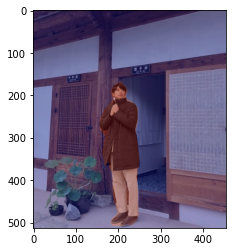

In [5]:
# person 라벨만 추출하기

img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [6]:
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

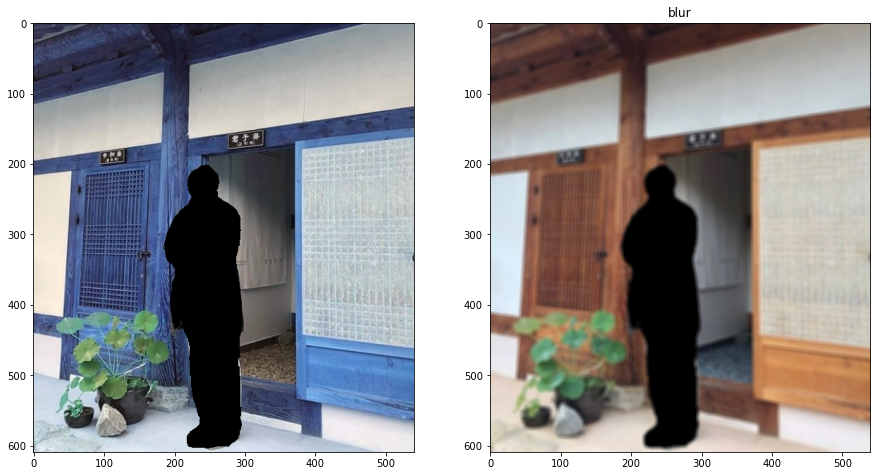

In [7]:
img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg = cv2.bitwise_and(img_orig, img_bg_mask)

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 2, 1)
plt.imshow(img_bg)

# 배경 이미지에 blur 처리하기
img_bg_blur = cv2.blur(img_bg, (7, 7))
ax = plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
ax.set_title('blur')

plt.show()

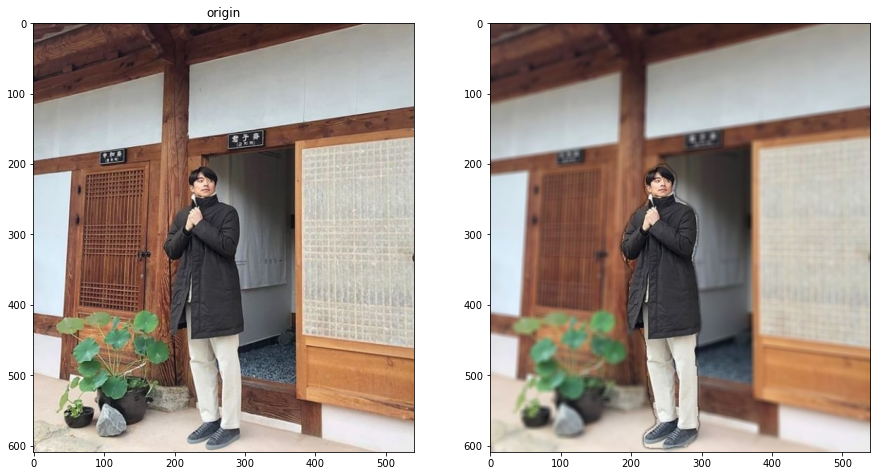

In [8]:
# 배경과 인물 이미지를 합성하기

plt.figure(figsize=(15, 10))
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)

ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
ax.set_title('origin')
ax = plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
print(img_mask_color.shape, img_orig.shape, img_bg_blur.shape)

(609, 540, 3) (609, 540, 3) (609, 540, 3)


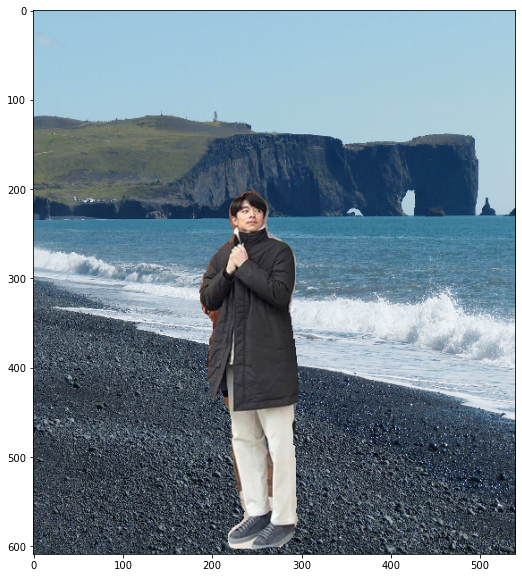

In [10]:
# 크로마키 적용하기

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/sea.jpg'
img_bg = cv2.imread(img_path)

img_bg = cv2.resize(img_bg, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
img_bg = cv2.bitwise_and(img_bg, img_bg_mask)

plt.figure(figsize=(15, 10))
img_concat = np.where(img_mask_color==255, img_orig, img_bg)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
# 고양이, 자동차 인물 모드 만들기
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpeg'
cat_img_orig = cv2.imread(img_path) 
print (cat_img_orig.shape)

img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/car.jpg'
car_img_orig = cv2.imread(img_path) 
print (car_img_orig.shape)

(436, 653, 3)
(330, 500, 3)


In [12]:
# 첫 단계: 준비된 이미지를 네트워크에 입력한다.

cat_img_resized, cat_seg_map = MODEL.run(cat_img_orig)
print (cat_img_orig.shape, cat_img_resized.shape, cat_seg_map.max()) # seg_map.max(): pascal voc 라벨 수
car_img_resized, car_seg_map = MODEL.run(car_img_orig)
print (car_img_orig.shape, car_img_resized.shape, car_seg_map.max()) # seg_map.max(): pascal voc 라벨 수

(436, 653, 3) (342, 513, 3) 17
(330, 500, 3) (338, 513, 3) 15


In [13]:
# car(7), cat(8) 라벨만 추출하기

img_show = car_img_resized.copy()
seg_map = np.where(car_seg_map == 7, 7, 0) # 예측 중 car만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
car_img_mask = img_mask.astype(np.uint8)
car_color_mask = cv2.applyColorMap(car_img_mask, cv2.COLORMAP_JET)
car_img_show = cv2.addWeighted(img_show, 0.6, car_color_mask, 0.35, 0.0)

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(car_img_show, cv2.COLOR_BGR2RGB))

img_show = cat_img_resized.copy()
seg_map = np.where(cat_seg_map == 8, 8, 0) # 예측 중 cat만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
cat_img_mask = img_mask.astype(np.uint8)
cat_color_mask = cv2.applyColorMap(cat_img_mask, cv2.COLORMAP_JET)
cat_img_show = cv2.addWeighted(img_show, 0.6, cat_color_mask, 0.35, 0.0)

ax = plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cat_img_show, cv2.COLOR_BGR2RGB))
plt.show()


In [14]:
img_mask_up = cv2.resize(car_img_mask, car_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, car_img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)
img_mask_up = cv2.resize(cat_img_mask, cat_img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, cat_img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

car_img_mask_color = cv2.cvtColor(car_img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(car_img_mask_color)
car_img_bg = cv2.bitwise_and(car_img_orig, img_bg_mask)

fig = plt.figure(figsize=(15, 10))
ax = plt.subplot(2, 2, 1)
plt.imshow(car_img_bg)

# 차 배경 이미지에 blur 처리하기
car_img_bg_blur = cv2.blur(car_img_bg, (5,5))
ax = plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(car_img_bg_blur, cv2.COLOR_BGR2RGB))
ax.set_title('car_blur')

cat_img_mask_color = cv2.cvtColor(cat_img_mask_up, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(cat_img_mask_color)
cat_img_bg = cv2.bitwise_and(cat_img_orig, img_bg_mask)

ax = plt.subplot(2, 2, 3)
plt.imshow(cat_img_bg)

# 고양이 배경 이미지에 blur 처리하기
cat_img_bg_blur = cv2.blur(cat_img_bg, (6, 6))
ax = plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(cat_img_bg_blur, cv2.COLOR_BGR2RGB))
ax.set_title('cat_blur')

plt.show()

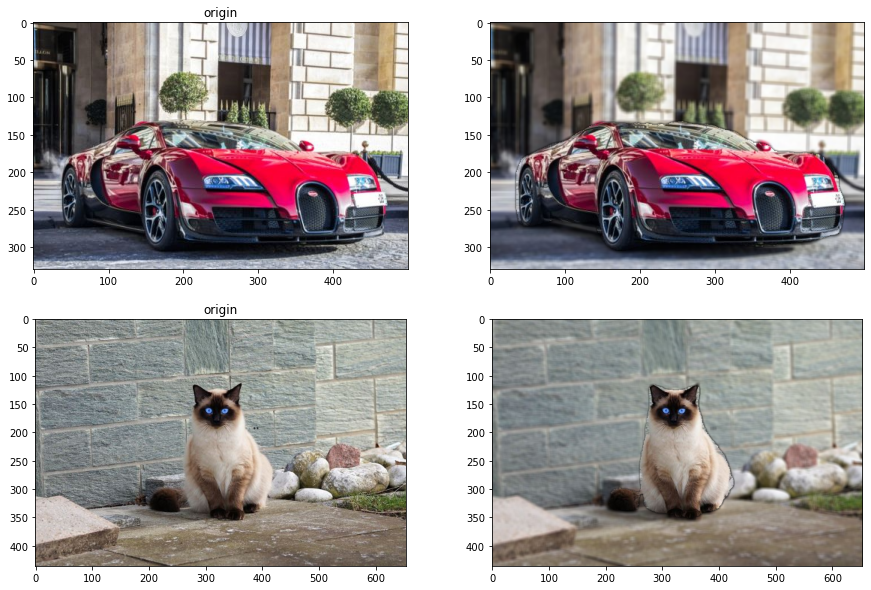

In [15]:
# 배경과 대상 이미지를 합성하기

fig = plt.figure(figsize=(15, 10))

ax = plt.subplot(2, 2, 1)
plt.imshow(cv2.cvtColor(car_img_orig, cv2.COLOR_BGR2RGB))
ax.set_title('origin')
img_concat = np.where(car_img_mask_color==255, car_img_orig, car_img_bg_blur)
ax = plt.subplot(2, 2, 2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

ax = plt.subplot(2, 2, 3)
plt.imshow(cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB))
ax.set_title('origin')
img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
ax = plt.subplot(2, 2, 4)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

plt.show()

사진에서의 문제점   


###### 해결 방안   
마스크와 원본사진을 연산한 이미지에 blur를 적용하지 말고 마스크와 blur가 적용된 원본과 연산하면 경계선을 해결할 수 있다

In [16]:
cat_img_bg_blur = cv2.blur(cat_img_orig, (6, 6))
cat_img_bg_blur = cv2.bitwise_and(cat_img_bg_blur, img_bg_mask)

fig = plt.figure(figsize=(15, 5))

ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(cat_img_orig, cv2.COLOR_BGR2RGB))
ax.set_title('origin')
img_concat = np.where(cat_img_mask_color==255, cat_img_orig, cat_img_bg_blur)
ax = plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))

plt.show()

3D Depth Camera 활용하기   
https://m.blog.naver.com/panoptics/221336152952

깊이 영상(Depth image)활용하기   
https://towardsdatascience.com/depth-prediction-autonomous-driving-18d05ff25dd6    
https://sites.google.com/view/struct2depth   

IR(적외선)을 활용한 사례   
https://ai.googleblog.com/2020/04/udepth-real-time-3d-depth-sensing-on.html